<h3>Import Libraries

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

<h3> Read data

In [3]:
#Load the list of the genres
genre = pd.read_csv('data/u.genre', sep='|', header=None, encoding='latin1', index_col=False)[0].tolist()
#Load the information about the movies, add in column names
movies = pd.read_csv('data/u.item', sep='|', header=None, encoding='latin1', index_col=False,
                     names = ['movie_id','movie title','release date','video release date','IMDb URL'] + genre)
# Display the overview of the movies data
print(movies.shape)
movies.head()

(1682, 24)


,movie_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
#Load the demographic information of users
users = pd.read_csv('data/u.user', sep='|', header=None, encoding='latin1', index_col=False,
                     names = ['user_id','age','gender','occupation','zip code'])
users.head()

,user_id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [5]:
# Load the data 
ratings = pd.read_csv('data/u.data', sep='\t', header=None, names=['user_id','movie_id','rating','timestamp'])
# Display the overview of the ratings dataset
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


<h1> Data Preprocessing

<h3> Data Cleaning

In [6]:
# Check for missing values in each dataframe
print("Number of missing values in ratings data: ",ratings.isna().sum().sum())
print("Number of missing values in users data: ",users.isna().sum().sum())
print("Number of missing values in movies data: ",movies.isna().sum())

Number of missing values in ratings data:  0
Number of missing values in users data:  0
Number of missing values in movies data:  movie_id                 0
movie title              0
release date             1
video release date    1682
IMDb URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children's               0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64


<h5> Preprocessing for movies data

In [7]:
# Drop the 'video release date' in the 'movies' dataset as it only contains NA values
# Remove columns that are less relevant in further analysis
movies = movies.drop(columns=['video release date','IMDb URL','release date']+genre)

In [8]:
# Remove the year in the movie title as it is repeated in the release date
movies['movie title'] = movies['movie title'].str.extract(r'^(.*?)\s*\(\d+\)$')
movies

,movie_id,movie title
0,1,Toy Story
1,2,GoldenEye
2,3,Four Rooms
3,4,Get Shorty
4,5,Copycat
...,...,...
1677,1678,Mat' i syn
1678,1679,B. Monkey
1679,1680,Sliding Doors
1680,1681,You So Crazy


In [9]:
#Remove movies that has <= 200 ratings
rating_counts = ratings['movie_id'].value_counts()
valid_movies = rating_counts[rating_counts.values > 200].index
movies = movies[movies['movie_id'].isin(valid_movies)]


In [10]:
# Display the updated overview of the movies dataset
print(movies.shape)
movies.head()

(117, 2)


,movie_id,movie title
0,1,Toy Story
3,4,Get Shorty
6,7,Twelve Monkeys
7,8,Babe
8,9,Dead Man Walking


<h5> Preprocessing for users data

In [11]:
# Drop excess information as we are divding users into 4 groups based on their age and gender
users = users.drop(columns = ['occupation','zip code'])

In [12]:
# Display the overview of the users dataset
print(users.shape)
users.head()

(943, 3)


,user_id,age,gender
0,1,24,M
1,2,53,F
2,3,23,M
3,4,24,M
4,5,33,F


<h5> Preprocessing for ratings data

In [13]:
# Drop the timestamp column as it is irelevant in this analysis
ratings = ratings.drop(columns=['timestamp']) 
# Drop the rows without movie id in valid movies
ratings = ratings[ratings['movie_id'].isin(valid_movies)]

In [14]:
# Display the updated overview of the ratings dataset
print(ratings.shape)
ratings.head()

(33480, 3)


,user_id,movie_id,rating
1,186,302,3
6,115,265,2
10,62,257,2
12,200,222,5
22,299,144,4


<h3> Feature Engineering

In [15]:
# Group the users into 4 groups based on their age and gender
users.loc[(users['gender'] == 'M') & (users['age'] < 30), 'Category'] = 'Male, Young'
users.loc[(users['gender'] == 'M') & (users['age'] >= 30), 'Category'] = 'Male, Adult'
users.loc[(users['gender'] == 'F') & (users['age'] < 30), 'Category'] = 'Female, Young'
users.loc[(users['gender'] == 'F') & (users['age'] >= 30), 'Category'] = 'Female, Adult'

# Drop the age and gender columns
users = users.drop(columns = ['age', 'gender'])
users

,user_id,Category
0,1,"Male, Young"
1,2,"Female, Adult"
2,3,"Male, Young"
3,4,"Male, Young"
4,5,"Female, Adult"
...,...,...
938,939,"Female, Young"
939,940,"Male, Adult"
940,941,"Male, Young"
941,942,"Female, Adult"


In [16]:
# Transform the ratings from a discrete range into a boolean value
# Use column 'Like' to store the value
ratings['like'] = ratings['rating'].apply(lambda x:  x >= 4)

In [17]:
#Combine the users dataset and the ratings dataset
ratings= pd.merge(ratings,users, on = 'user_id')
ratings

,user_id,movie_id,rating,like,Category
0,186,302,3,False,"Female, Adult"
1,186,385,4,True,"Female, Adult"
2,186,588,4,True,"Female, Adult"
3,186,322,5,True,"Female, Adult"
4,186,333,3,False,"Female, Adult"
...,...,...,...,...,...
33475,941,273,3,False,"Male, Young"
33476,941,1,5,True,"Male, Young"
33477,941,294,4,True,"Male, Young"
33478,855,179,3,False,"Male, Adult"


In [18]:
#Combine the movies dataset and the ratings dataset
ratings= pd.merge(ratings,movies, on = 'movie_id')
ratings.head()

,user_id,movie_id,rating,like,Category,movie title
0,186,302,3,False,"Female, Adult",L.A. Confidential
1,115,302,4,True,"Male, Adult",L.A. Confidential
2,62,302,3,False,"Female, Young",L.A. Confidential
3,299,302,4,True,"Male, Young",L.A. Confidential
4,160,302,5,True,"Male, Young",L.A. Confidential


In [19]:
# Seperate the ratings dataset into 4 datasets based on the user category and store 
male_young_ratings = ratings[ratings['Category'] == 'Male, Young'].drop(columns=['Category'])
male_young_ratings.to_csv('processed_data/male_young_ratings.csv')

male_adult_ratings = ratings[ratings['Category'] == 'Male, Adult'].drop(columns=['Category'])
male_adult_ratings.to_csv('processed_data/male_adult_ratings.csv')

female_young_ratings = ratings[ratings['Category'] == 'Female, Young'].drop(columns=['Category'])
female_young_ratings.to_csv('processed_data/female_young_ratings.csv')

female_adult_ratings = ratings[ratings['Category'] == 'Female, Adult'].drop(columns=['Category'])
female_adult_ratings.to_csv('processed_data/female_adult_ratings.csv')

In [31]:
# Overview for each group of data
print(f'Overview of the dataset for group Male, Young: {male_young_ratings.shape}\n',male_young_ratings.head())
print(f'Overview of the dataset for group Male, Adult: {male_adult_ratings.shape}\n',male_adult_ratings.head())
print(f'Overview of the dataset for group Female, Young: {female_young_ratings.shape}\n',female_young_ratings.head())
print(f'Overview of the dataset for group Female, Young: {female_adult_ratings.shape}\n',female_adult_ratings.head())

Overview of the dataset for group Male, Young: (11838, 5)
     user_id  movie_id  rating  like        movie title
3       299       302       4  True  L.A. Confidential
4       160       302       5  True  L.A. Confidential
7       216       302       5  True  L.A. Confidential
9       293       302       4  True  L.A. Confidential
10      305       302       4  True  L.A. Confidential
Overview of the dataset for group Male, Adult: (13250, 5)
     user_id  movie_id  rating  like        movie title
1       115       302       4  True  L.A. Confidential
6       145       302       4  True  L.A. Confidential
8       271       302       5  True  L.A. Confidential
11       90       302       5  True  L.A. Confidential
12       13       302       5  True  L.A. Confidential
Overview of the dataset for group Female, Young: (3935, 5)
     user_id  movie_id  rating   like        movie title
2        62       302       3  False  L.A. Confidential
19      229       302       5   True  L.A. Confide

<h1> Bandit Simulator

In [21]:
from tqdm import tqdm

class ReplaySimulator(object):
    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, random_seed=1):
        # Set the random seed for reproducibility
        np.random.seed(random_seed)

        # Store input data and parameters
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # Number of visits to replay/simulate
        self.n_visits = n_visits

        # Number of runs to average over
        self.n_iterations = n_iterations

        # Items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)

        # Visitors in the historical reward_history
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)

    def reset(self):
        # Initialize counters for item samples and rewards
        self.n_item_samples = np.zeros(self.n_items)
        self.n_item_rewards = np.zeros(self.n_items)

    def replay(self):
        # Store simulation results
        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
            # Reset counters for each iteration
            self.reset()

            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
                found_match = False
                while not found_match:
                    # Choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # Select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]

                    # Check if this interaction exists in the history
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]

                    found_match = reward.shape[0] > 0

                reward_value = reward.iloc[0]

                self.record_result(visit, item_idx, reward_value)

                # Record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)

                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)

                results.append(result)

        return results

    def select_item(self):
        # This method selects an item randomly
        return np.random.randint(self.n_items)

    def record_result(self, visit, item_idx, reward):
        # This method records the result of an interaction and updates item statistics

        # Update the number of times the item has been sampled
        self.n_item_samples[item_idx] += 1

        # Update the fraction of time the item has resulted in a reward
        alpha = 1. / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])


# $\epsilon$-Greedy Simulations - Parameter Selection

Update arm selection for $\epsilon$-Greedy

In [22]:
class EpsilonGreedyReplayer(ReplaySimulator):
    '''
    A class to provide functionality for simulating the replayer method on an epsilon-Greedy bandit algorithm.
    '''

    def __init__(self, epsilon, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        super(EpsilonGreedyReplayer, self).__init__(n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations)
    
        # parameter to control exploration vs exploitation
        self.epsilon = epsilon
    
    def select_item(self):
        
        # decide to explore or exploit
        if np.random.uniform() < self.epsilon: # explore
            item_id = super(EpsilonGreedyReplayer, self).select_item()
            
        else: # exploit
            item_id = np.argmax(self.n_item_rewards)
            
        return item_id

<h3> Hyperparameter Selection

In [23]:
n_visits = 20000
n_iterations = 20
n_test_visits = 1000

item_col_name = 'movie_id'
visitor_col_name = 'user_id'
reward_col_name = 'like'

##### $\epsilon$ = 0.10

In [24]:
# Male, Young
epsilon = 0.10
epsilon_10_results_my = EpsilonGreedyReplayer(epsilon, n_visits, male_young_ratings,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_10_results_my_df = pd.DataFrame(epsilon_10_results_my)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [10:53<00:00, 32.69s/it]


In [28]:
# Male, Adult
epsilon_10_results_ma = EpsilonGreedyReplayer(epsilon, n_visits, male_adult_ratings,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_10_results_ma_df = pd.DataFrame(epsilon_10_results_ma)

100%|██████████| 20/20 [14:46<00:00, 44.33s/it]


In [29]:
# Female, Young
epsilon_10_results_fy = EpsilonGreedyReplayer(epsilon, n_visits, female_young_ratings,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_10_results_fy_df = pd.DataFrame(epsilon_10_results_fy)

100%|██████████| 20/20 [17:08<00:00, 51.40s/it]


In [32]:
# Female, Adult
epsilon_10_results_fa = EpsilonGreedyReplayer(epsilon, n_visits, female_adult_ratings,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_10_results_fa_df = pd.DataFrame(epsilon_10_results_fa)

100%|██████████| 20/20 [16:31<00:00, 49.58s/it]


In [33]:
epsilon_10_results_my_df.to_csv('output/epsilon_10_my.csv')
epsilon_10_results_ma_df.to_csv('output/epsilon_10_ma.csv')
epsilon_10_results_fy_df.to_csv('output/epsilon_10_fy.csv')
epsilon_10_results_fa_df.to_csv('output/epsilon_10_fa.csv')


In [34]:
epsilon_10_results_my_df = pd.read_csv('output/epsilon_10_my.csv', index_col=0)
epsilon_10_results_ma_df = pd.read_csv('output/epsilon_10_ma.csv', index_col=0)
epsilon_10_results_fy_df = pd.read_csv('output/epsilon_10_fy.csv', index_col=0)
epsilon_10_results_fa_df = pd.read_csv('output/epsilon_10_fa.csv', index_col=0)

##### $\epsilon$ = 0.05

In [39]:
# Male, Young
epsilon = 0.05
epsilon_05_results_my = EpsilonGreedyReplayer(epsilon, n_visits, male_young_ratings,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_05_results_my_df = pd.DataFrame(epsilon_05_results_my)

100%|██████████| 20/20 [10:49<00:00, 32.50s/it]


In [36]:
# Male, Adult
epsilon = 0.05
epsilon_05_results_ma = EpsilonGreedyReplayer(epsilon, n_visits, male_adult_ratings,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_05_results_ma_df = pd.DataFrame(epsilon_05_results_ma)

100%|██████████| 20/20 [12:50<00:00, 38.52s/it]


In [38]:
# Female, Young
epsilon = 0.05
epsilon_05_results_fy = EpsilonGreedyReplayer(epsilon, n_visits, female_young_ratings,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_05_results_fy_df = pd.DataFrame(epsilon_05_results_fy)

100%|██████████| 20/20 [17:28<00:00, 52.41s/it]


In [41]:
# Female, Adult
epsilon = 0.05
epsilon_05_results_fa = EpsilonGreedyReplayer(epsilon, n_visits, female_adult_ratings,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_05_results_fa_df = pd.DataFrame(epsilon_05_results_fa)

100%|██████████| 20/20 [15:45<00:00, 47.29s/it]


In [42]:
epsilon_05_results_my_df.to_csv('output/epsilon_05_my.csv')
epsilon_05_results_ma_df.to_csv('output/epsilon_05_ma.csv')
epsilon_05_results_fy_df.to_csv('output/epsilon_05_fy.csv')
epsilon_05_results_fa_df.to_csv('output/epsilon_05_fa.csv')

In [43]:
epsilon_05_results_my_df = pd.read_csv('output/epsilon_05_my.csv', index_col=0)
epsilon_05_results_ma_df = pd.read_csv('output/epsilon_05_ma.csv', index_col=0)
epsilon_05_results_fy_df = pd.read_csv('output/epsilon_05_fy.csv', index_col=0)
epsilon_05_results_fa_df = pd.read_csv('output/epsilon_05_fa.csv', index_col=0)

In [51]:
epsilon_05_avg_results_my_df = epsilon_05_results_my_df.groupby('visit', as_index=False).mean()
epsilon_10_avg_results_my_df = epsilon_10_results_my_df.groupby('visit', as_index=False).mean()

epsilon_05_avg_results_ma_df = epsilon_05_results_ma_df.groupby('visit', as_index=False).mean()
epsilon_10_avg_results_ma_df = epsilon_10_results_ma_df.groupby('visit', as_index=False).mean()

epsilon_05_avg_results_fy_df = epsilon_05_results_fy_df.groupby('visit', as_index=False).mean()
epsilon_10_avg_results_fy_df = epsilon_10_results_fy_df.groupby('visit', as_index=False).mean()

epsilon_05_avg_results_fa_df = epsilon_05_results_fa_df.groupby('visit', as_index=False).mean()
epsilon_10_avg_results_fa_df = epsilon_10_results_fa_df.groupby('visit', as_index=False).mean()

/var/folders/dl/r4pqw5gj1bn541sr99s_h9jm0000gn/T/ipykernel_36915/2107281566.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((ax.get_yticks()*100).astype(int))


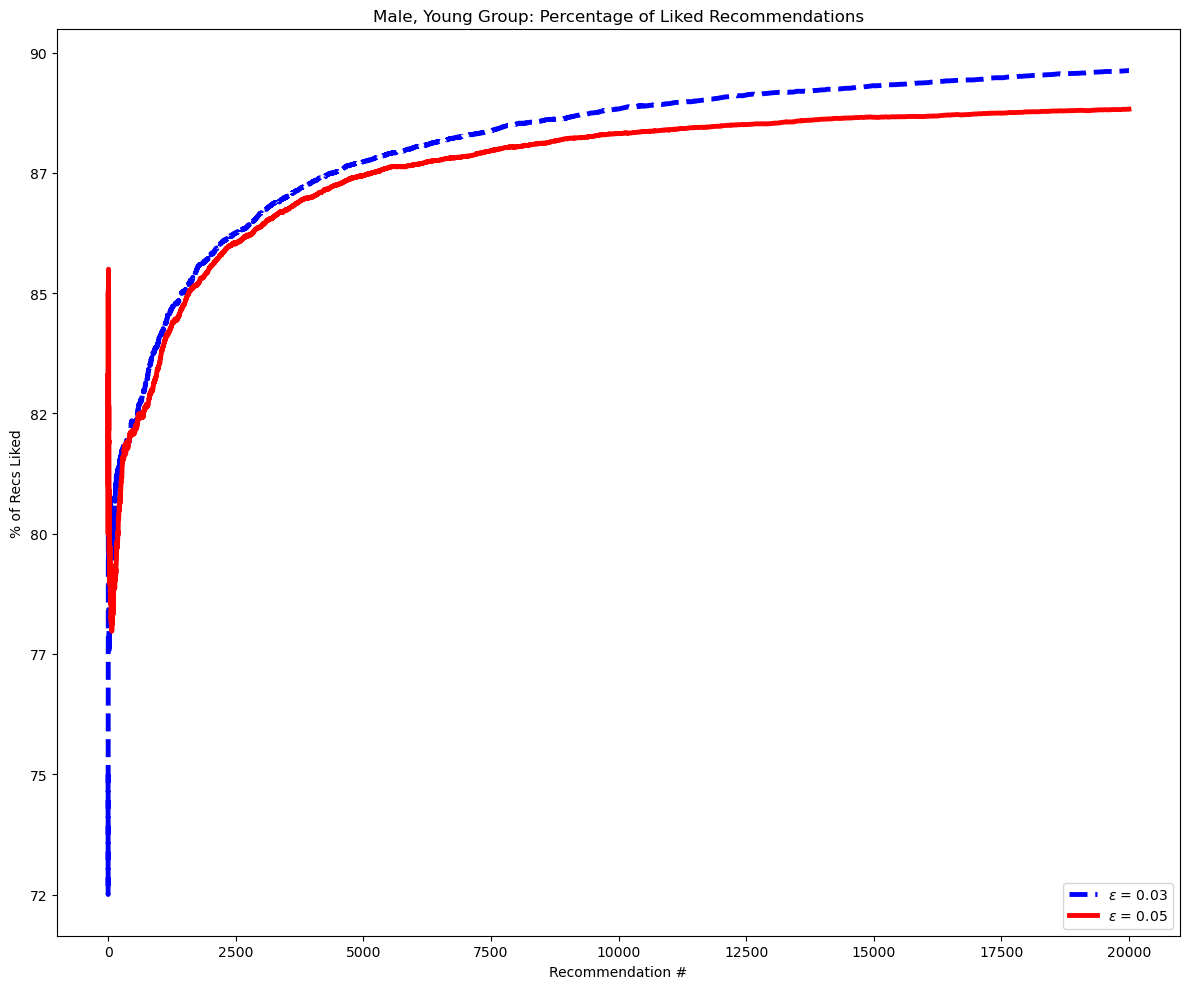

In [56]:
fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_my_df, style) in [(epsilon_05_avg_results_my_df, 'b--'),
                                (epsilon_10_avg_results_my_df, 'r-')]:
    
    ax.plot(avg_results_my_df.visit, avg_results_my_df.fraction_relevant, style, linewidth=3.5)

ax.set_title('Male, Young Group: Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['$\epsilon$ = 0.03',
           '$\epsilon$ = 0.05',
           '$\epsilon$ = 0.10'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()

/var/folders/dl/r4pqw5gj1bn541sr99s_h9jm0000gn/T/ipykernel_36915/899888967.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((ax.get_yticks()*100).astype(int))


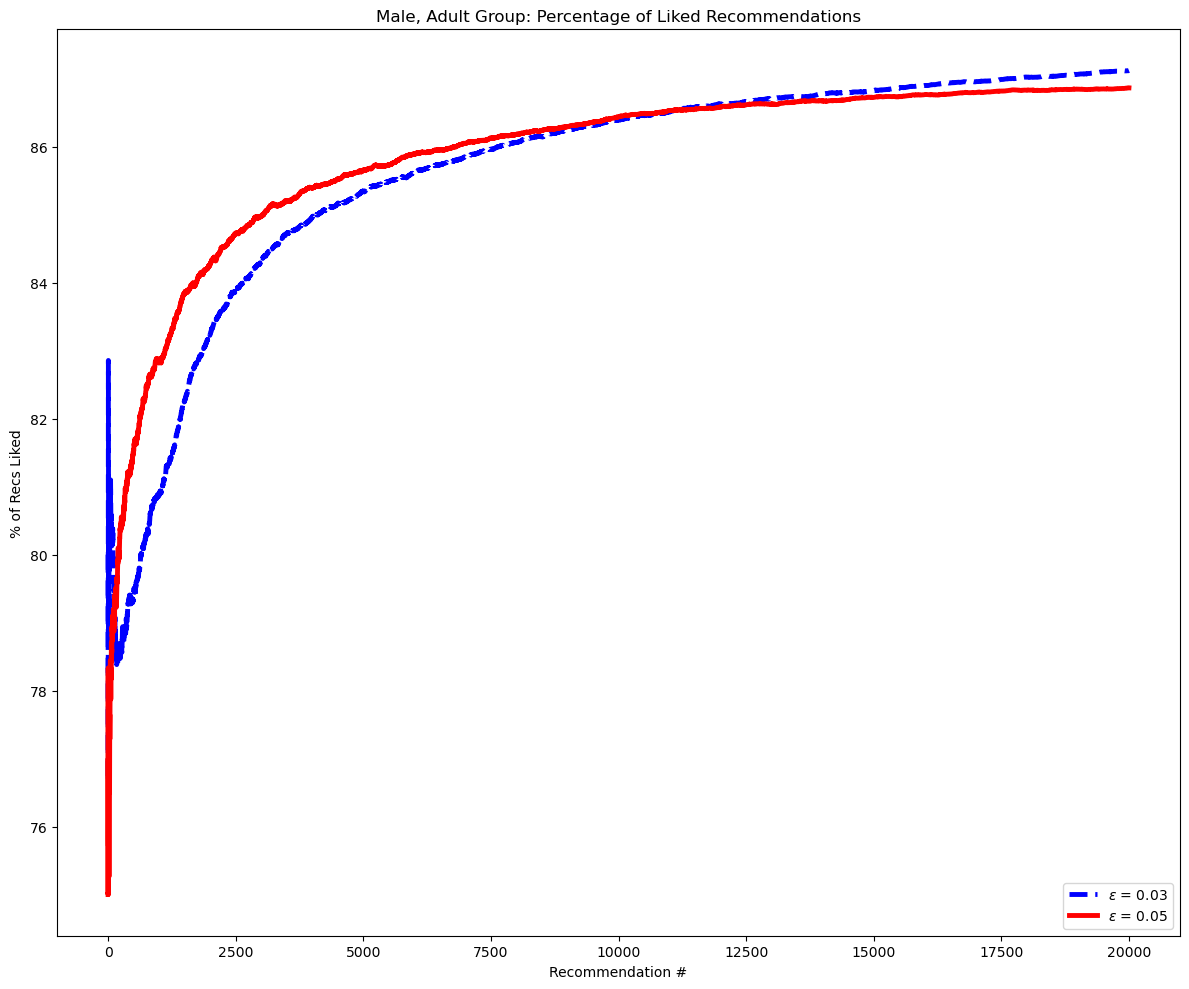

In [57]:
fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_ma_df, style) in [(epsilon_05_avg_results_ma_df, 'b--'),
                                (epsilon_10_avg_results_ma_df, 'r-')]:
    
    ax.plot(avg_results_ma_df.visit, avg_results_ma_df.fraction_relevant, style, linewidth=3.5)

ax.set_title('Male, Adult Group: Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['$\epsilon$ = 0.03',
           '$\epsilon$ = 0.05',
           '$\epsilon$ = 0.10'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()

/var/folders/dl/r4pqw5gj1bn541sr99s_h9jm0000gn/T/ipykernel_36915/2090298753.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((ax.get_yticks()*100).astype(int))


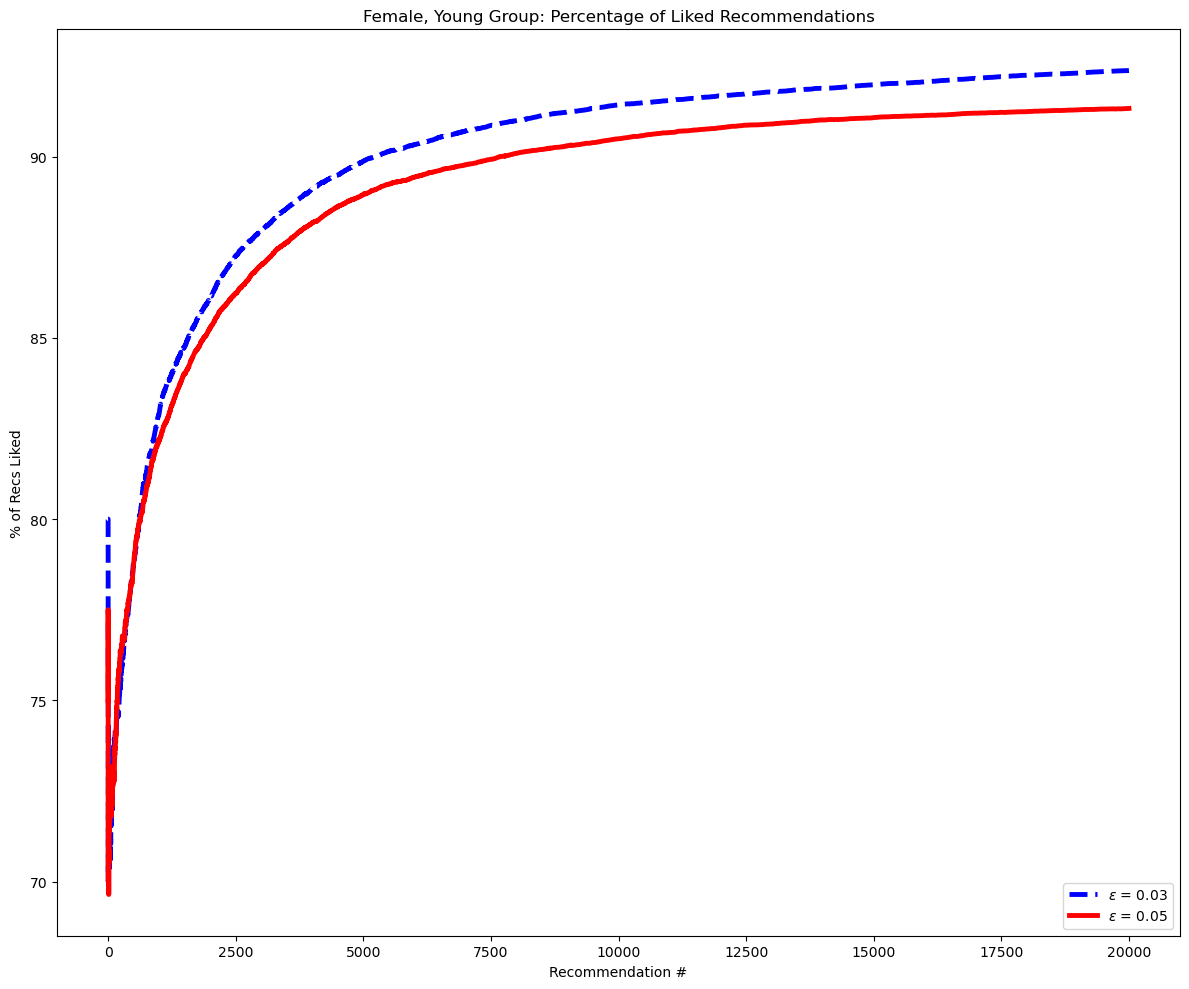

In [58]:
fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_fy_df, style) in [(epsilon_05_avg_results_fy_df, 'b--'),
                                (epsilon_10_avg_results_fy_df, 'r-')]:
    
    ax.plot(avg_results_fy_df.visit, avg_results_fy_df.fraction_relevant, style, linewidth=3.5)

ax.set_title('Female, Young Group: Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['$\epsilon$ = 0.03',
           '$\epsilon$ = 0.05',
           '$\epsilon$ = 0.10'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()

/var/folders/dl/r4pqw5gj1bn541sr99s_h9jm0000gn/T/ipykernel_36915/2384971517.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((ax.get_yticks()*100).astype(int))


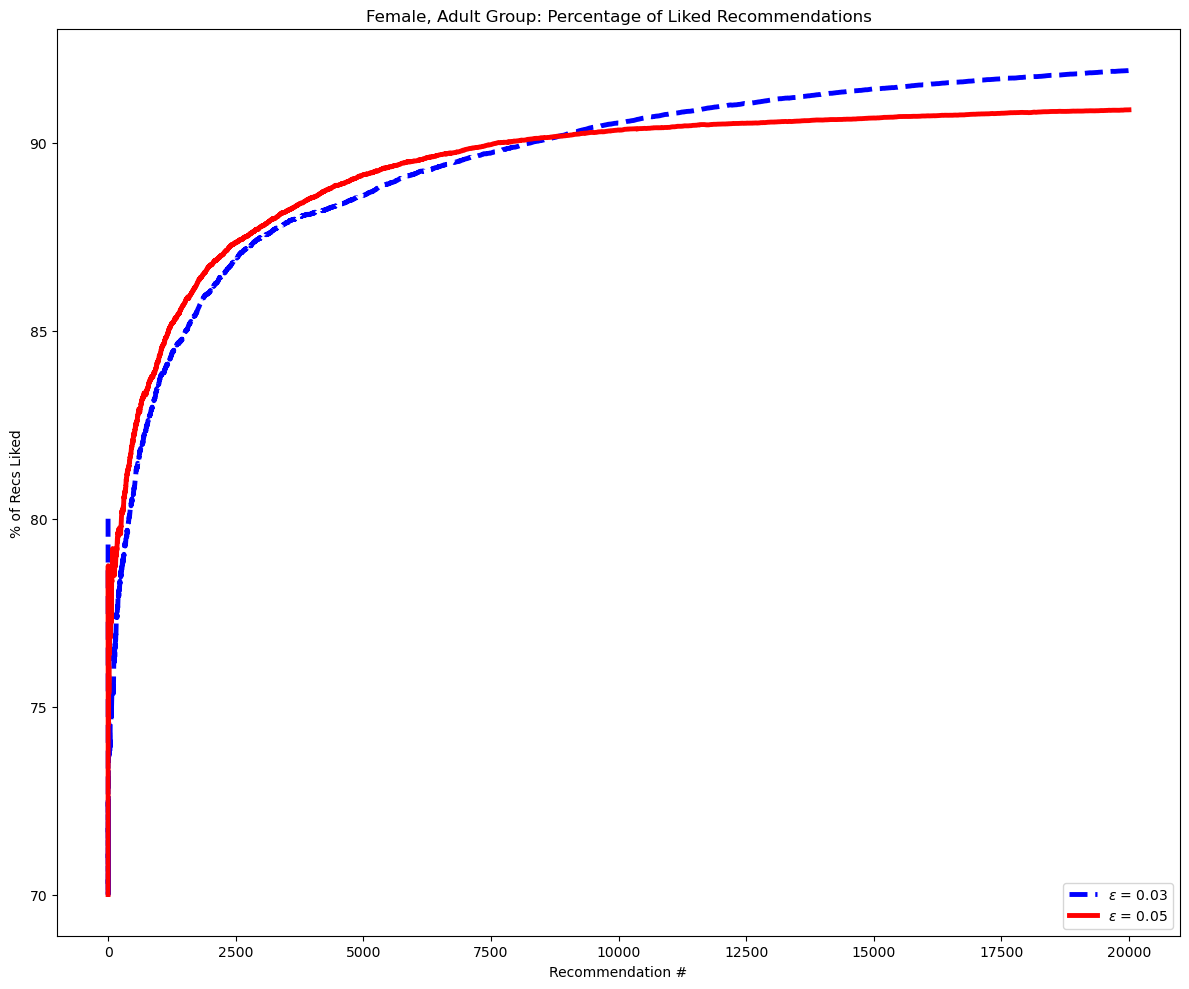

In [59]:
fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_fa_df, style) in [(epsilon_05_avg_results_fa_df, 'b--'),
                                (epsilon_10_avg_results_fa_df, 'r-')]:
    
    ax.plot(avg_results_fa_df.visit, avg_results_fa_df.fraction_relevant, style, linewidth=3.5)

ax.set_title('Female, Adult Group: Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['$\epsilon$ = 0.03',
           '$\epsilon$ = 0.05',
           '$\epsilon$ = 0.10'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()

From the graph it is evident $\epsilon$ = 0.10 does not perform as optimal as $\epsilon$ = 0.05 for each user category.  
Hence we choose $\epsilon$ = 0.05 for further analysis as it ensures optimal performance while maintaining a higher probability for exploration.